<a href="https://colab.research.google.com/github/pinballsurgeon/sweeping_analysis/blob/main/emergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## installs

In [1]:
!pip install pytrends
!pip install joypy

# install openai
!pip install openai

  Created wheel for pytrends: filename=pytrends-4.8.0-py3-none-any.whl size=16126 sha256=89cde68f3133bf07ad769882ce78f680fccba196309343f891986c9a5882413a
  Stored in directory: /root/.cache/pip/wheels/07/6f/5c/8174f98dec1bfbc7d5da4092854afcbcff4b26c3d9b66b5183
Successfully built pytrends
     |████████████████████████████████| 40 kB 5.0 MB/s 
     |████████████████████████████████| 161 kB 46.9 MB/s 
  Created wheel for openai: filename=openai-0.15.0-py3-none-any.whl size=50093 sha256=9e20238b23411c275377285baf06761ca2b7c0234d4ad4180e8659b9edfa37af
  Stored in directory: /root/.cache/pip/wheels/bd/b1/b5/01a94056fd87ef0ed913b2fa6f1161076b730cf1449f579ab7
Successfully built openai


## imports

In [92]:
import numpy
import pandas 
import re
import string

import time 
from difflib import SequenceMatcher

from pytrends.request import TrendReq
from pytrends         import dailydata
import pytrends
from operator         import index

import joypy
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn 

import openai

import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

# supply openai api key via file 
openai.api_key = open('openai_key').read()


## seed config

In [140]:
# connection strenth minimum boost, base on standard deviation
std_factor = 1.6
pop_threshold = -.5

# batch size
batch_size = 30

# request object
req_obj = ['diseases', 'symptoms', 'behaviors', 'objects', 'emotions', 'home remedies', 'products', 'complications']

# seed topics
topics = ['Asthma', 'Bronchitis', 'Sinusitis', 'Emergency', 'Walgreens', 'Cvs', 'Eye', 'Knee', 'Skull', 'Ear', 'Nose', 'Rash', 'Arthritis'
        , 'Tinnitus', 'Burn', 'Allergy', 'Ambulance', 'Accident', 'Poison', 'Cough', 'Watery eye', 'Ringworm', 'Antibiotic', 'Doctor', 'Clinic'
        , 'Hypertension', 'Pharmacy', 'Primary care', 'Bruise', 'Sprain', 'Strain', 'Exczema', 'Cellulitis', 'Abscesses', 'Strep throat'
        , 'Pain', 'Throbbing', 'Irritability', 'Sad', 'Happy', 'Mad' , 'Cancer', 'Surgery', 'Heart', 'Lungs', 'Throat', 'Mouth', 'Toothache'
        , 'Ear infection', 'Diabetes', 'Migranes', 'Pink eye', 'Bladder infection', 'Attention deficit', 'Depression', 'Anxiety']



## helper functions
  1. get_trend_frame(topics, years): returns a dataframe of topic trends
  2. stack_nodes_vertically(df_features):
  3. build_node_labels(df_flat):

In [101]:
### 1. for a given list of topics, return dataframe of interests from pytrend
def get_trend_frame(topics, years):

  # batch management
  batch_counter = 0
  batch_idx = 0

  # initialize return frame
  df_total = pandas.DataFrame()

  # for each provided 
  for topic in topics:

    # prevent saturation of api endpoint
    if batch_counter > batch_size:
      print('')
      batch_idx+=1
      print('completed retrieval of batch %d - %d rows of %d' % (batch_idx, round(batch_idx * batch_size), len(topics) ))
      batch_counter=0
      time.sleep(30)


    # pytrend request
    pytrend = TrendReq()
    pytrend.build_payload(kw_list=[topic]
                         ,geo="US-FL"
                         ,timeframe=( 'today %s-y' % (years)))
    
    # load trend request
    df = pytrend.interest_over_time()

    batch_counter+=1

    try:

      # add column for new topic
      df_total[topic] = df[topic]

    except:
      print('failed to add topic - %s ' % (topic))

  # drop nans
  df_total = df_total.dropna()

  # return standard frame
  return df_total

In [5]:
### 2. for each topic and interval of time, stack a vertical dataframe of value counts
def stack_nodes_vertically(df_features):

  # initialize buffers resources
  df_stk=pandas.DataFrame()
  globalst=[]

  # for each feature
  for col in df_features:                      # topic

      # for each time interval
      for val in df_features.index.weekofyear: # weeknum

          try:

            # time sensitive
            fs_val = df_features[col][val]       # full spectrum
                
            if fs_val > pop_threshold:

              # iterate through each instance of max bin occurence, determining number of weeks written
              for x in range(0,int(abs(fs_val) * 100)):
                
                  # build buffer list
                  lst = [val, val, col]
                  globalst.append(lst)

            else:
                  # build buffer list
                  lst = [val, None, None]
                  globalst.append(lst)

          except Exception as e: # work on python 3.x
              print(col)              
              print(val)
              print(fs_val)
              print('Failed to upload to ftp: '+ str(e))

  # materialize vertically flattened
  df_flat = pandas.DataFrame(globalst
                            ,columns=['WeekNum'
                            ,'WeekNum_Rct'
                            ,'Flower_Tot'])
  
  return df_flat

In [6]:
### 3. prefix ridgemap/joyplot labels with weeknum average
def build_node_labels(df_flat):
  
  # get all distinct nodes
  df_stats = df_flat.groupby('Flower_Tot').agg(['mean', 'count']).reset_index()

  # rename columns to node labels
  df_stats.columns = [' '.join(col).strip() for col in df_stats.columns.values]

  # sort by average time interval
  df_stats = df_stats.sort_values(by='WeekNum mean',ascending=True)

  # include average into node label
  df_stats['Name'] = ( ( df_stats['WeekNum mean'] * 100) + 1000).astype('int').astype('str') + ' '+ df_stats['Flower_Tot']

  # update flattened node space with averaged names
  for index, row in df_stats.iterrows():
      df_flat['Flower_Tot'] = df_flat['Flower_Tot'].replace(row['Flower_Tot'], row['Name'])

  return df_flat

In [7]:
### 4. display ridgeplot of time frame, for 
def get_ridgeplot(df_flat):

  # configure and build ridgeplot
  fig, axes = joypy.joyplot(df_flat
                            , column=['WeekNum', 'WeekNum_Rct']
                            , by='Flower_Tot'
                            , overlap=1.2
                            , fill=True
                            , figsize=(22,22)
                            , x_range = [0,52]
                            , colormap=cm.cool                         
                            , ylim='own'
                          )

  # write ridgeplot
  plt.savefig('frank_jj.png')

  # plot
  plt.show()

In [8]:
### 5. send openai question, receive response
def get_openai_response(question):

    # format open au request
    response = openai.Completion.create(
                      engine="text-davinci-001",
                      prompt=question,
                      temperature=.01,
                      max_tokens=250,
                      top_p=1,
                      frequency_penalty=50,
                      presence_penalty=0 )

    # parse and process open ai response
    response_choices = response["choices"]

    # replace blanks
    response = response_choices[0]["text"].strip('\n')

    return response

In [79]:
def swap_tokens(chk_topics, new_topics):

  buffer_lst = []

# for each graphed topics
  for chk_topic in chk_topics:

    buffer_lst.append(chk_topic)


  for new_topic in new_topics:

    # token validation checks

      new_topic_split = new_topic.split()
    
    # 1. check that not preceeded by short word
      if len(new_topic_split[0]) < 3:

        try:
          new_topic = new_topic_split[1]
        except:
          pass
        

      buffer_lst.append(new_topic)


  return buffer_lst


In [80]:
swap_tokens(['test','hat','visits'],['s visit','run', 'jump'])

['test', 'hat', 'visits', 'visit', 'run', 'jump']

In [76]:
's visit'.split()

['s', 'visit']

In [10]:
def get_pairwise_similarity(df_features, topics, std_factor):

  # pair wise correlation / similarity
  c = df_features.corr().abs()

  # flatten and sort
  so = c.unstack().sort_values(kind="quicksort")

  # remove low connections
  min_connection_strength = so.mean() + ( std_factor * so.std() )
  min_connection_cutoff = len(so) - len(so[so > min_connection_strength])

  # turn to frame
  df_slice = so[min_connection_cutoff:-len(topics)].to_frame()

  df_slice.reset_index(inplace=True)

  df_slice.columns = ['source','target','weight']

  return df_slice

In [11]:
def build_graph_network(df_slice):

  # build graph 
  G = nx.from_pandas_edgelist(df_slice
                            ,'source'          # parent
                            ,'target'          # child
                            , ['weight'])      # relationship


  # define plot area
  plt.figure(3,figsize=(22,22)) 


  # visualize graph 
  nx.draw_spring(G                        
      ,with_labels=True
      ,edge_color='gray'
      ,node_color='white'
      ,font_size=22)
  
  return G

In [88]:
def get_openai_generated_topics(topic, obj):
  
  new_tokens_list = []

  responses = []

  # retrieve 
  retrieval = get_openai_response('list one word %s related to %s' % (obj , topic))
  responses.append(retrieval)

  new_tokens = re.split("; |, |\*|\n",responses[0].lower())
  #new_tokens = re.split("; |, |\*|\n",retrieval.lower())
  #new_tokens_list.append(' '.join(new_tokens))


  return new_tokens

In [139]:
def get_related_topics(df):

  lst_buffer = []
  graph_topics = list(df['source'].unique())

  # batch management
  batch_counter = 0
  batch_idx = 0

  for graph_topic in graph_topics:

    for obj in req_obj:

      # prevent saturation of api endpoint
      if batch_counter > batch_size:
        print('')
        batch_idx+=1
        print('completed openai retrieval of batch %d - %d rows of %d' % (batch_idx, round(batch_idx * batch_size), len(graph_topics) * len(req_obj) ))
        batch_counter=0
        time.sleep(30)

      topic_list = get_openai_generated_topics(graph_topic, obj)

      for topic in topic_list:

        topic = topic.translate(string.punctuation)
        topic = re.sub(r'[^\w\s]','',topic)

        if len(topic) < 10 and len(topic) > 4:

          lst_buffer.append(topic)
      
      batch_counter+=1
    
  return lst_buffer

## gather, pre-process and stage graph data structure

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':


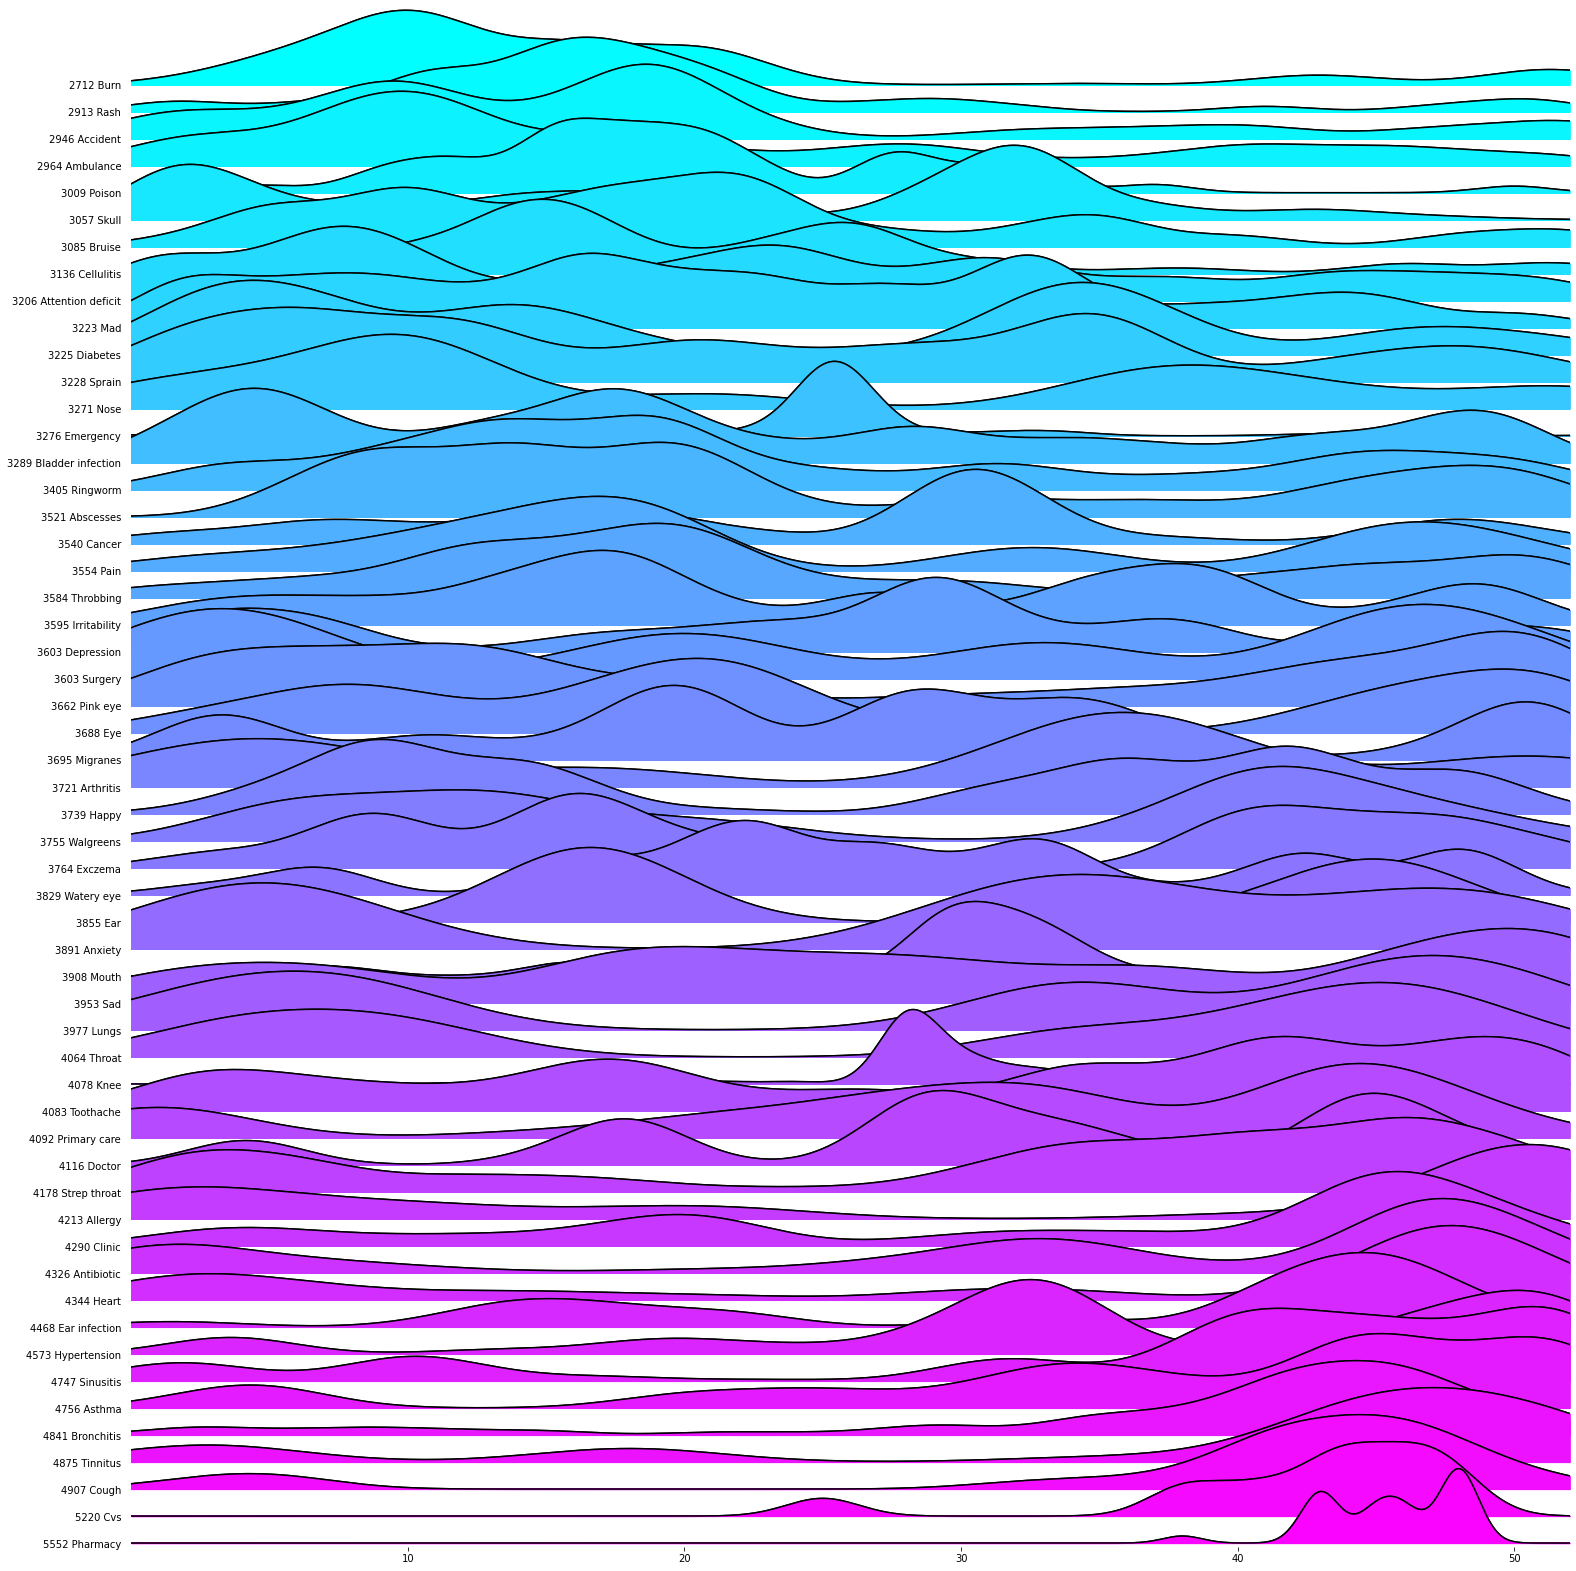

In [14]:
# request features
df_features = get_trend_frame(topics, '5')[topics]

# normalize feature space
df_features=(df_features-df_features.mean())/df_features.std()

# flatten feature space vertically
df_flat = stack_nodes_vertically(df_features)

# build node labels
df_flat = build_node_labels(df_flat)

# display ridgeplot of events
get_ridgeplot(df_flat)

In [16]:
#df_features
#df_slice

In [62]:
ff = get_openai_generated_topics("smoking")

print(ff)




there are many diseases related to smoking including lung cancer and emphysema. -coughing    -wheeziness or a whistling sound when you breathe. this may be caused by narrowed airways due to smoking and can leadto asthma attacks in some people who have the condition . asthma is one ofthe leading causesof death among smokers accounting for almost 1 out oft 3 deaths fromsmoking related illnesses each year) smoking cigarettes smoking cigars or pipes cigarette ashtray. lighter 1. relief – smoking can provide short-term respite from stress and negative emotions such as anxiety or depression there are many home remedies related to smoking. some people may use herbs or supplements such as nicotine gum and patches others try quitting cold turkey cigarettes lighters cigarettes cigars and smoking tobacco -cigarette smoking is a leading cause of preventable death in the united states. cigarettes contain more than 7,000 chemicals including over 70 known tocause cancer.-smoking increases your risk f

In [118]:
df_slice[(df_slice['weight']<0.85)]

source     target    weight
0         blood   cleaning  0.489543
1      cleaning      blood  0.489543
2          Rash  discharge  0.489601
3     discharge       Rash  0.489601
4       inhaler     gargle  0.489773
...         ...        ...       ...
2053    washing   cleaning  0.825602
2054   coughing      mucus  0.831294
2055      mucus   coughing  0.831294
2056      mucus   coughing  0.831294
2057   coughing      mucus  0.831294

[2058 rows x 3 columns]

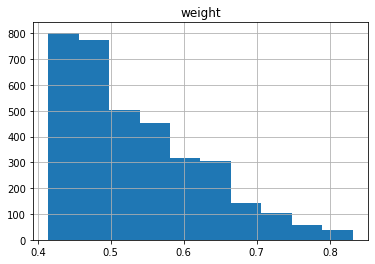

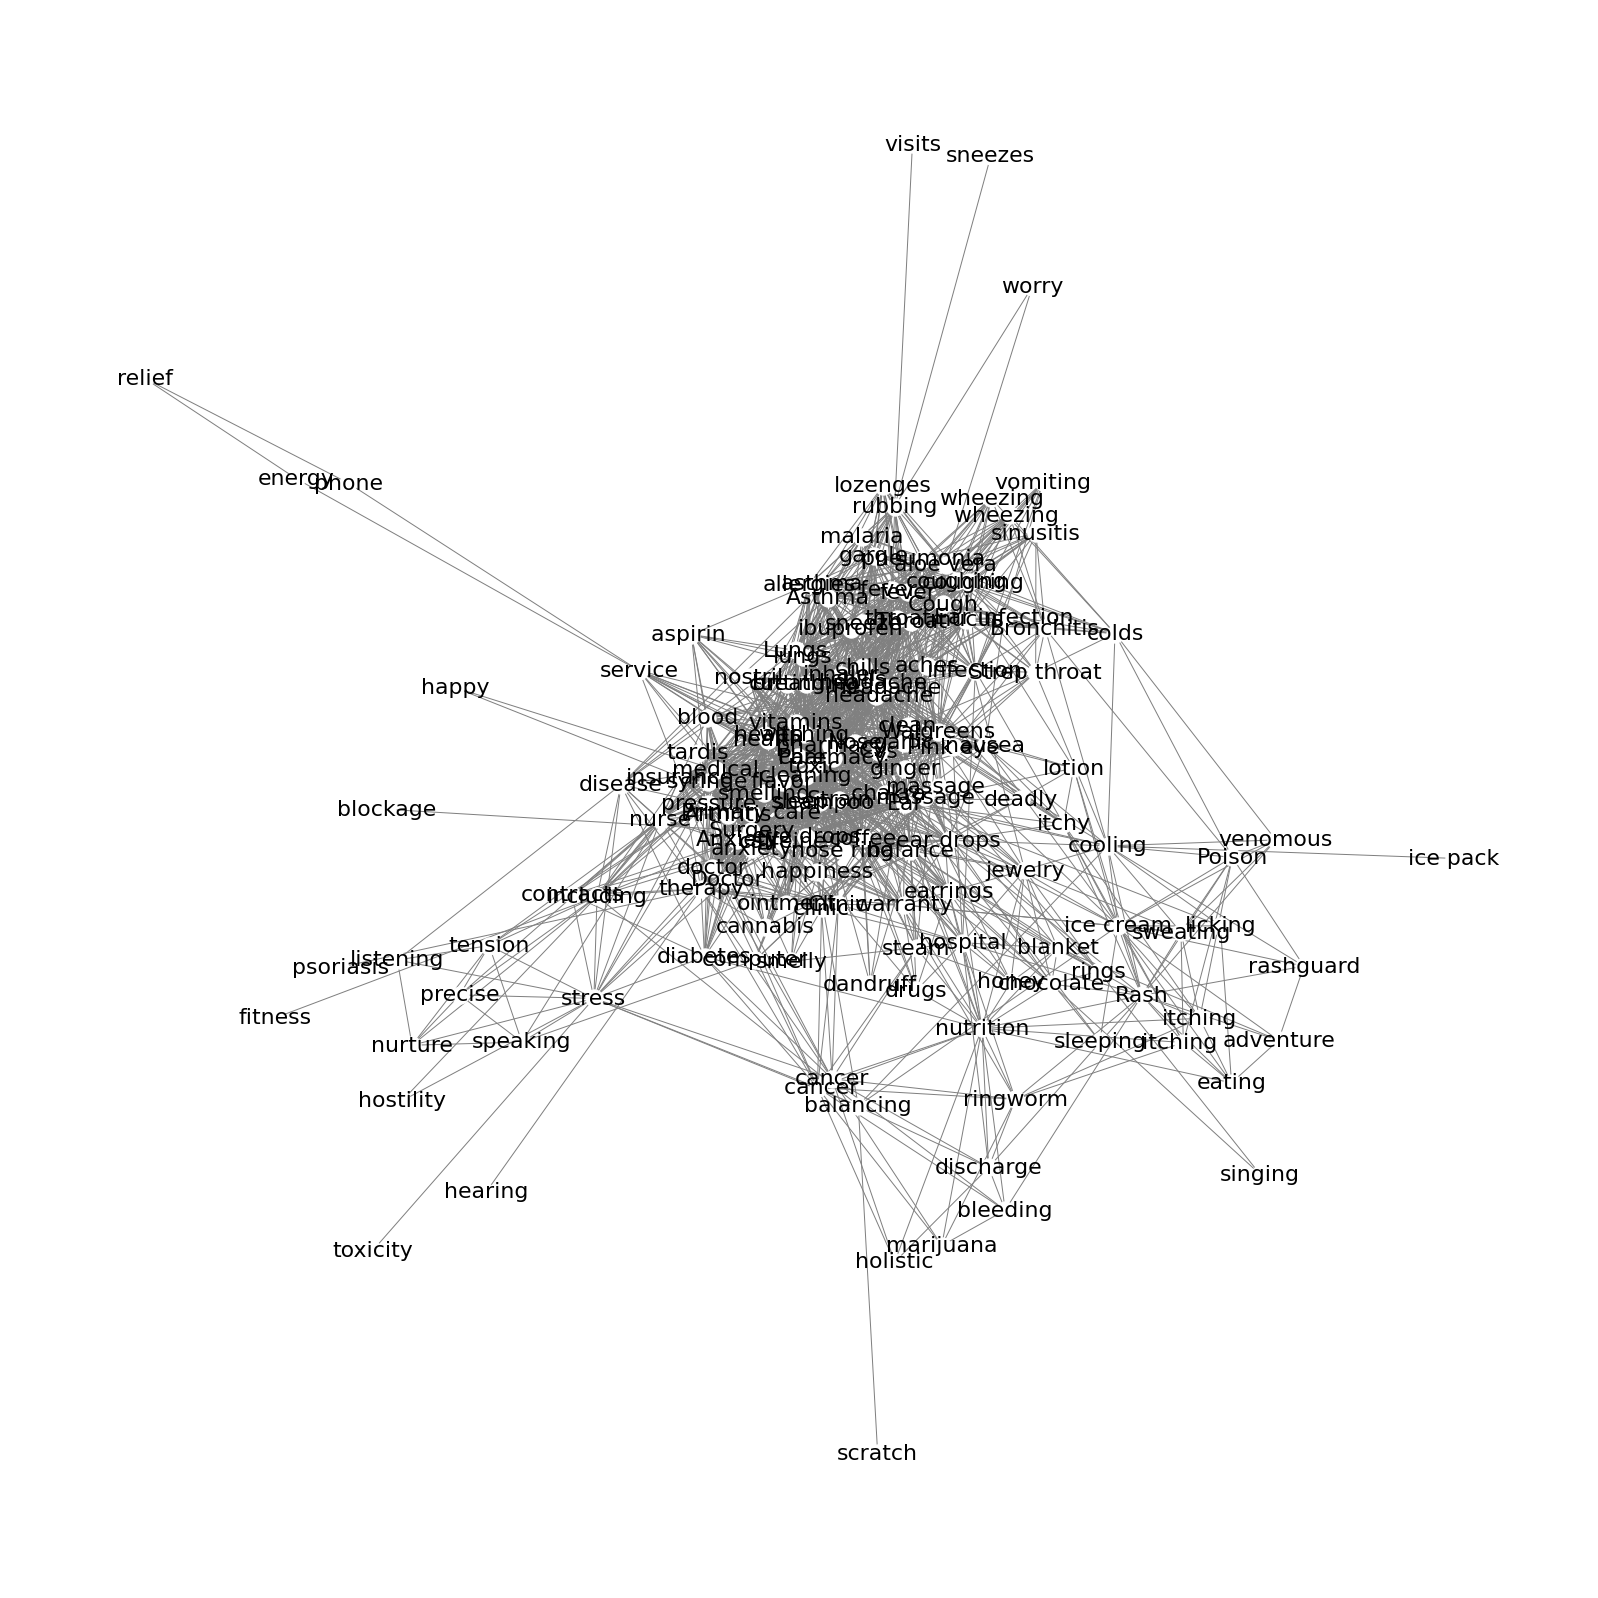

In [123]:
# time-based pairwise similiarity weights
df_slice = get_pairwise_similarity(df_features, topics, std_factor)

# reduce to realistic relationship weights
df_slice = df_slice[(df_slice['weight']<0.85)]
df_slice = df_slice[df_slice['source'] != df_slice['target'] ]

# display flattened histogram
df_slice.hist()

# build graph
G = build_graph_network(df_slice)

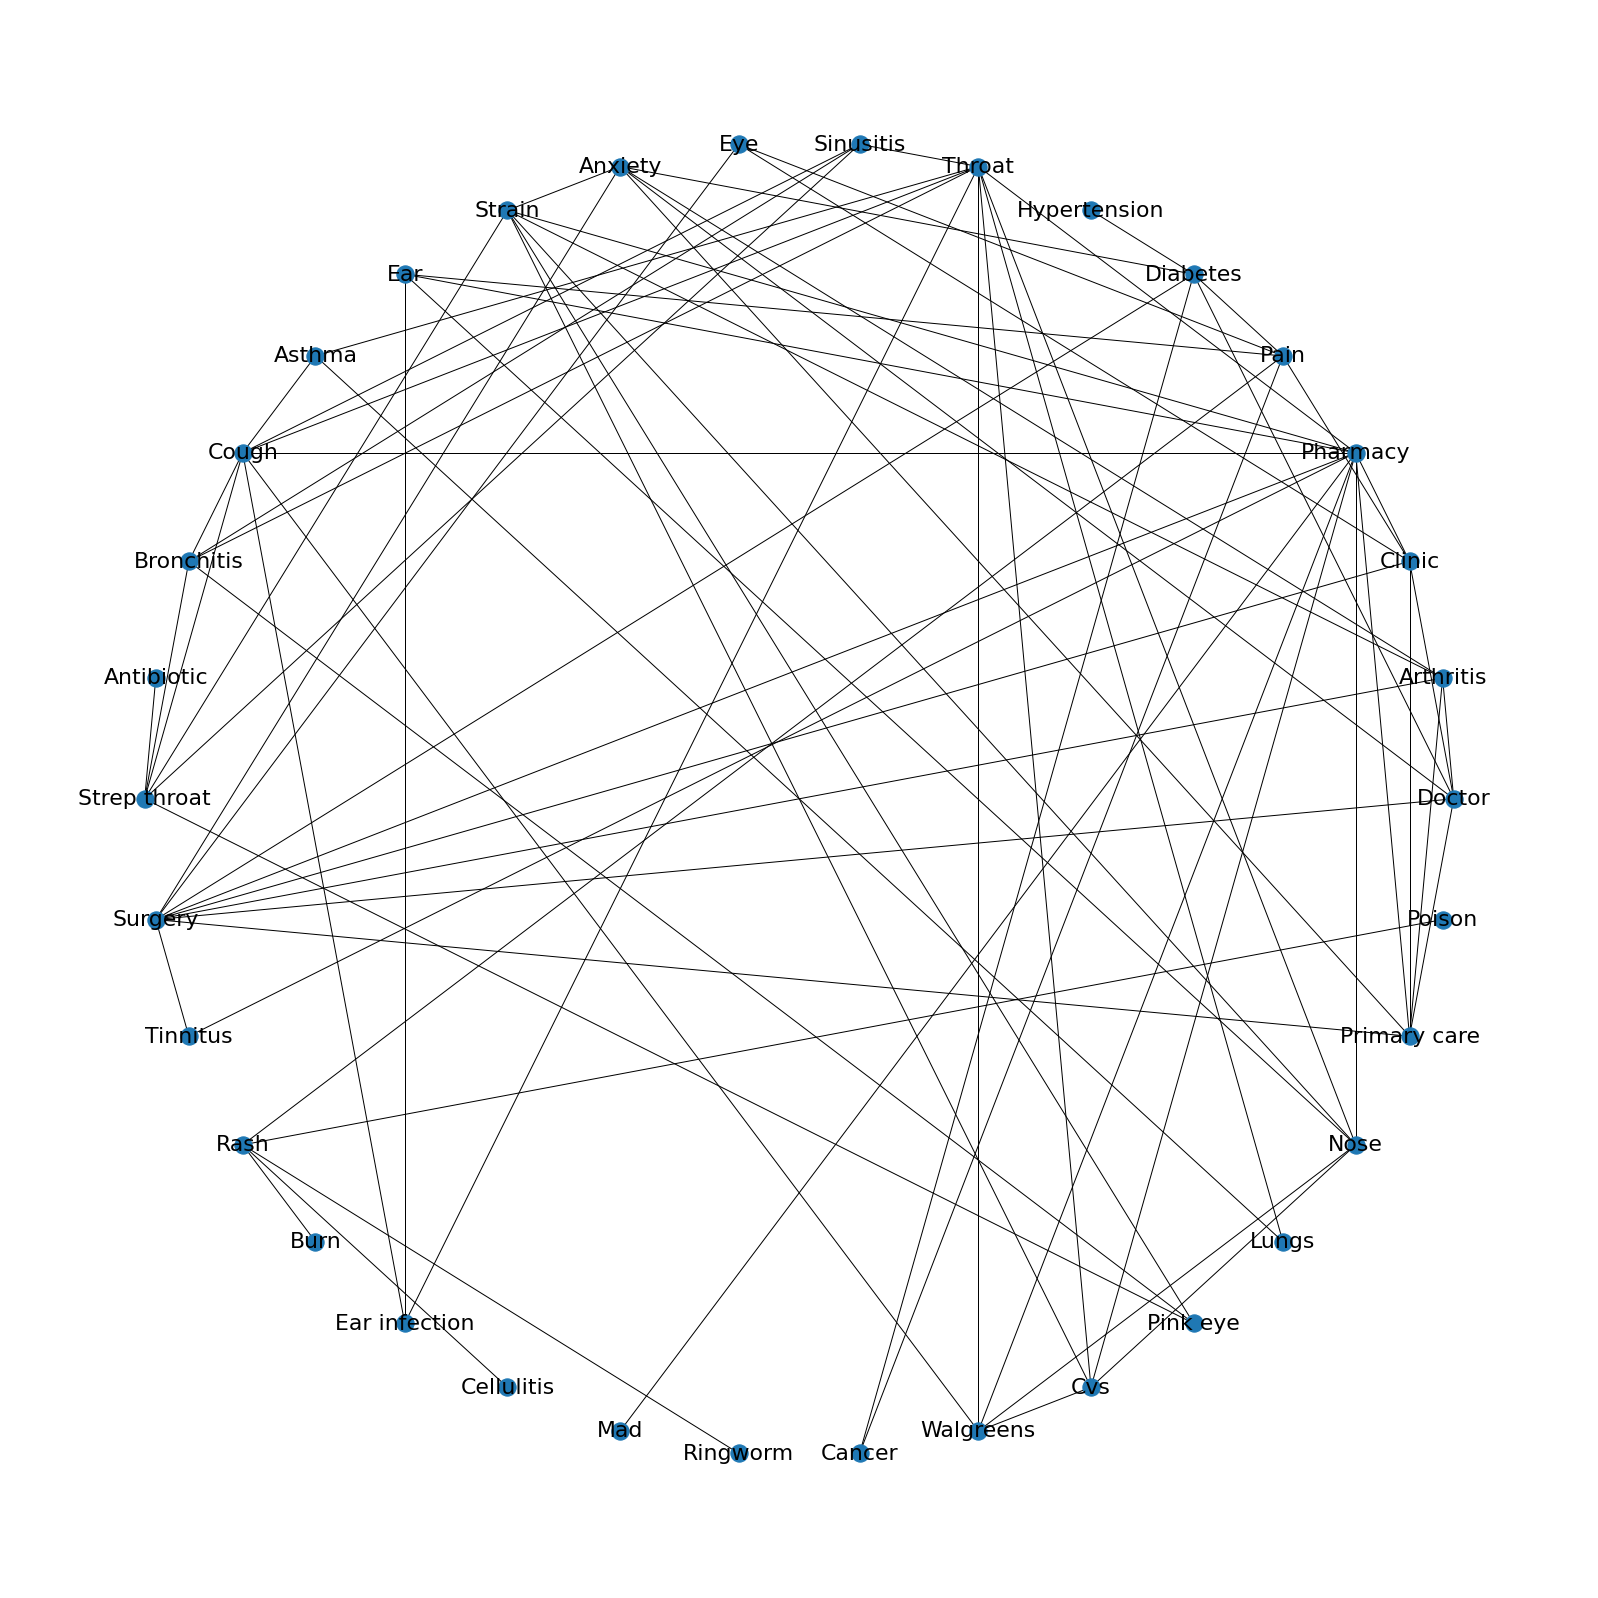

In [18]:
# circler plot
circ_pos = nx.circular_layout(G) 

# define plot area
plt.figure(3,figsize=(22,22)) 

#Use the networkx draw function to easily visualise the graph
nx.draw(G,circ_pos,with_labels=True,font_size=22)


In [19]:
# community detection

# community detection
c = list(greedy_modularity_communities(G))

# how many communities we detected
community_count=len(c)
print('Communities found - %s ' % community_count); print()

for community in range(community_count):
  
  print('Community %d - %s' % (community, sorted(c[community])))

Communities found - 4 

Community 0 - ['Anxiety', 'Arthritis', 'Cancer', 'Clinic', 'Diabetes', 'Doctor', 'Eye', 'Hypertension', 'Pain', 'Primary care', 'Surgery']
Community 1 - ['Antibiotic', 'Asthma', 'Bronchitis', 'Cough', 'Ear infection', 'Lungs', 'Pink eye', 'Sinusitis', 'Strep throat', 'Throat']
Community 2 - ['Cvs', 'Ear', 'Mad', 'Nose', 'Pharmacy', 'Strain', 'Tinnitus', 'Walgreens']
Community 3 - ['Burn', 'Cellulitis', 'Poison', 'Rash', 'Ringworm']


In [ ]:
### graph properties

# list nodes
G.nodes.items()

# number of edges in graph
G.number_of_edges()

# number of nodes in graph
G.number_of_nodes()

G.get_edge_data(0,1)

In [89]:
# existing community topics
chk_topics = list(df_slice['source'].unique())

# purposed community topics
new_topics = get_related_topics(df_slice)
print(new_topics)

# new topic list
gen_topics = list(set(swap_tokens(chk_topics, new_topics)))
print(gen_topics)

['cancer', 'leukemia', 'nurture', 'nurse', 'nurture', 'massage ', 'hospital', 'insurance', 'cleaning', 'caregiver', 'caretaker', 'infection', 'bleeding', 'bleeding', 'blood', 'cutting', 'scalpel', 'anxiety', 'suture', 'scalpel', 'scalpel', 'scalpel', 'diabetes', 'aches', 'holistic', 'doctor', 'nurturing', 'doctor', 'clinic', 'parasites', 'aliens', 's visits', 'anxiety', 'adventure', 'tardis', 'adventure', 'mystery', 'doctor', 'tardis', 'tardis', 'space', 'diabetes', 'pharmacy', 'drugs', 'pharmacy', 'drugs', 'pharmacy', 'happiness', 'pharmacy', 'drugs', 'pharmacy', 'drugs', 'pharmacy', 'stockouts', ' cancer', 'speaking', 'singing', 'anguish', 'betrayal', 'gargle', 'soreness', 'pneumonia', 'coughing', 'pneumonia', 'infection', 'pneumonia', 'pneumonia', 'pneumonia', 'pleurisy', 'pneumonia', 'wheezing', 'coughing', 'wheezing', 'coughing', 'inhaler', 'anxiety', 'inhalers', 'inhalers', 'inhalers', 'migraine', 'pressure', 'stress', 'stress', 'ibuprofen', 'ibuprofen', 'stress', 'pressure', 'he

In [ ]:
#print(df_features)


completed retrieval of batch 1 - 30 rows of 223

completed retrieval of batch 2 - 60 rows of 223

completed retrieval of batch 3 - 90 rows of 223


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



completed retrieval of batch 4 - 120 rows of 223

completed retrieval of batch 5 - 150 rows of 223

completed retrieval of batch 6 - 180 rows of 223

completed retrieval of batch 7 - 210 rows of 223


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':


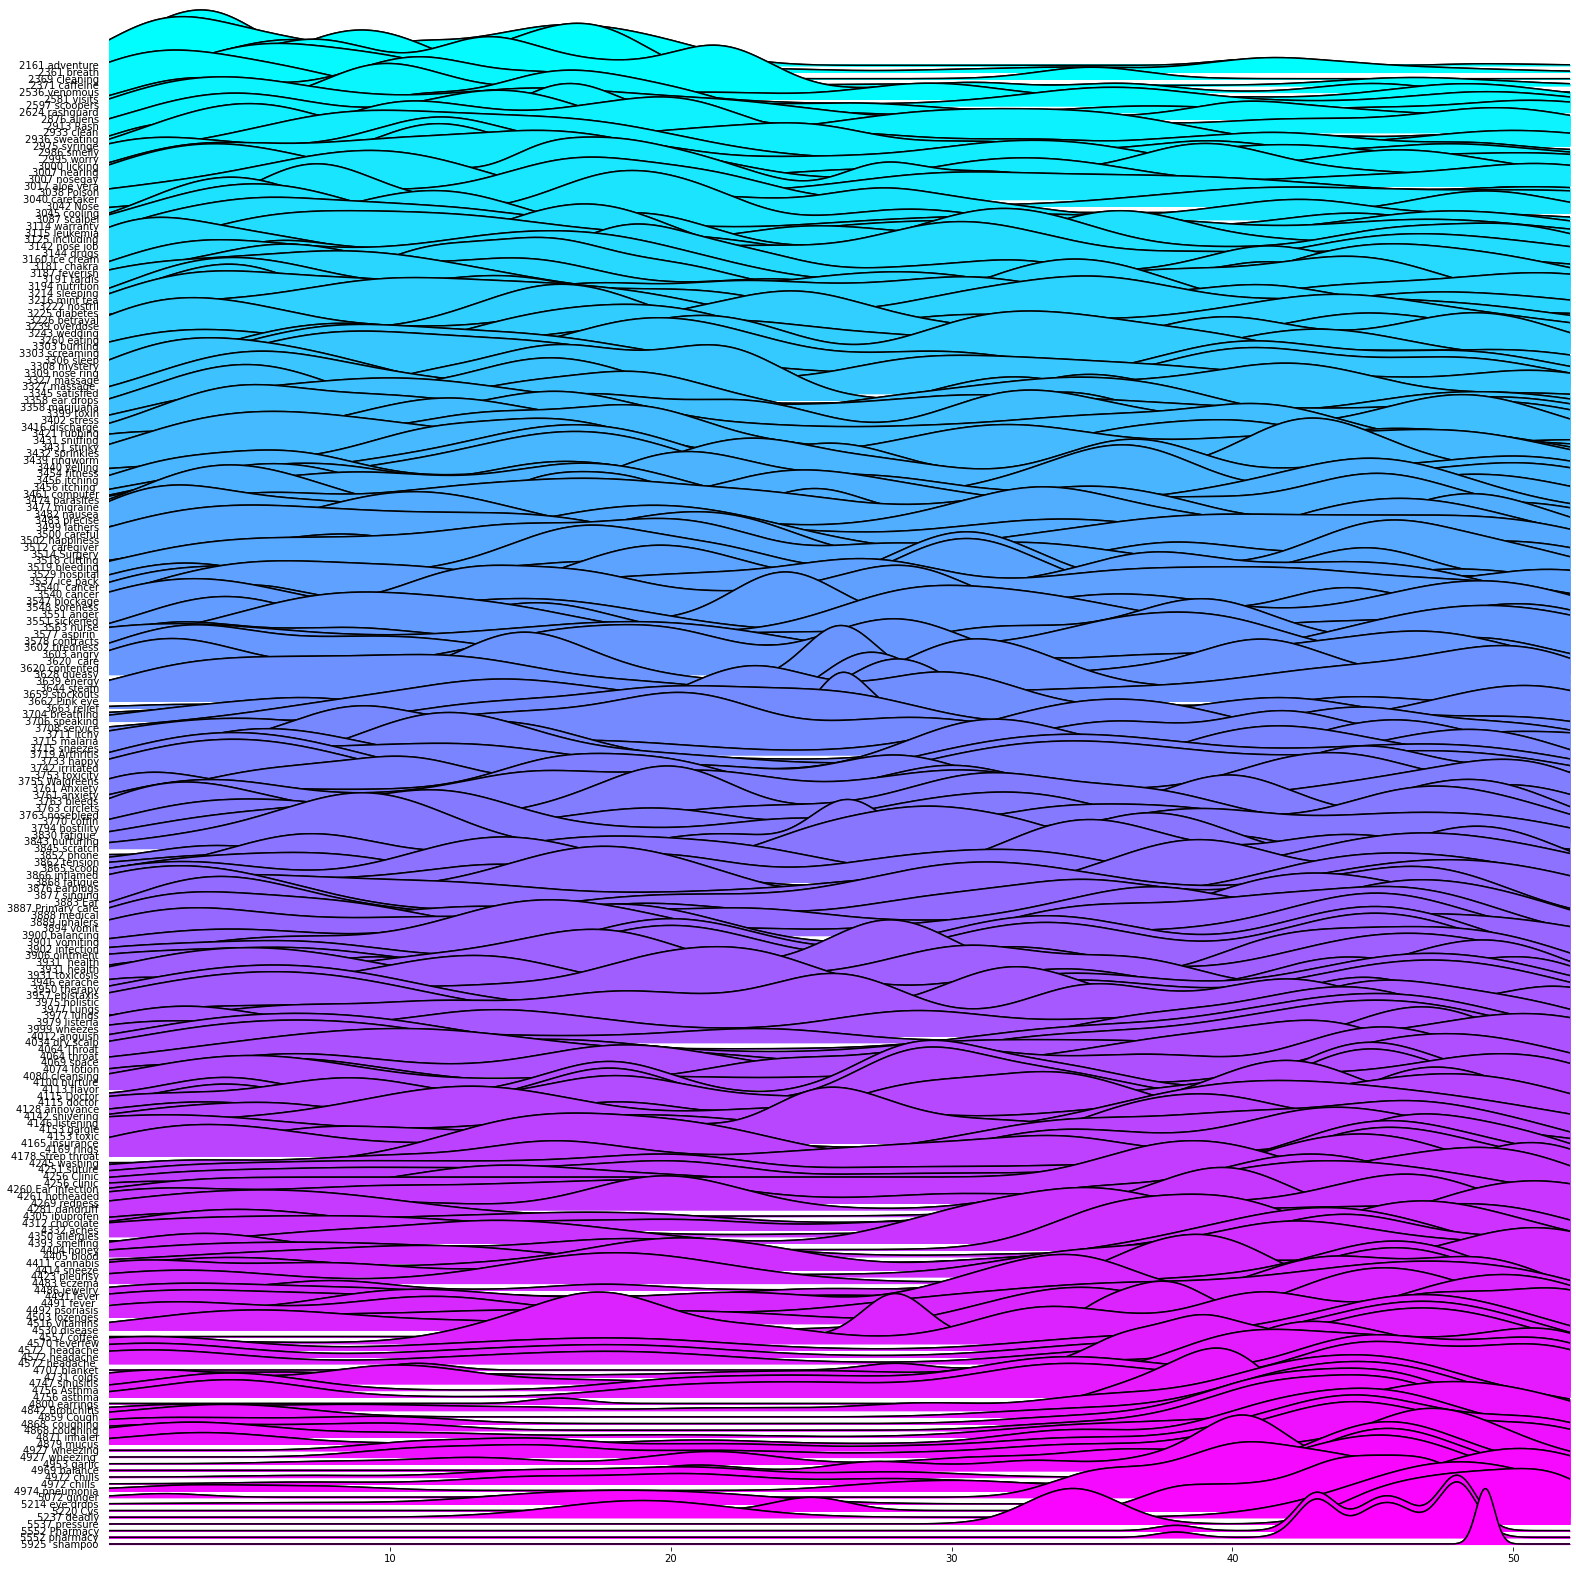

In [102]:
# request features
df_features = get_trend_frame(gen_topics, '5')[gen_topics]

# normalize feature space
df_features=(df_features-df_features.mean())/df_features.std()

# flatten feature space vertically
df_flat = stack_nodes_vertically(df_features)

# build node labels
df_flat = build_node_labels(df_flat)

# display ridgeplot of events
get_ridgeplot(df_flat)

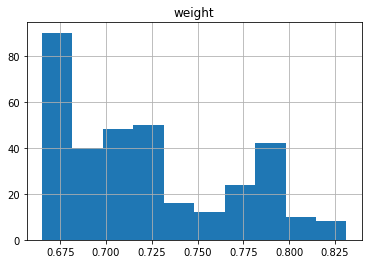

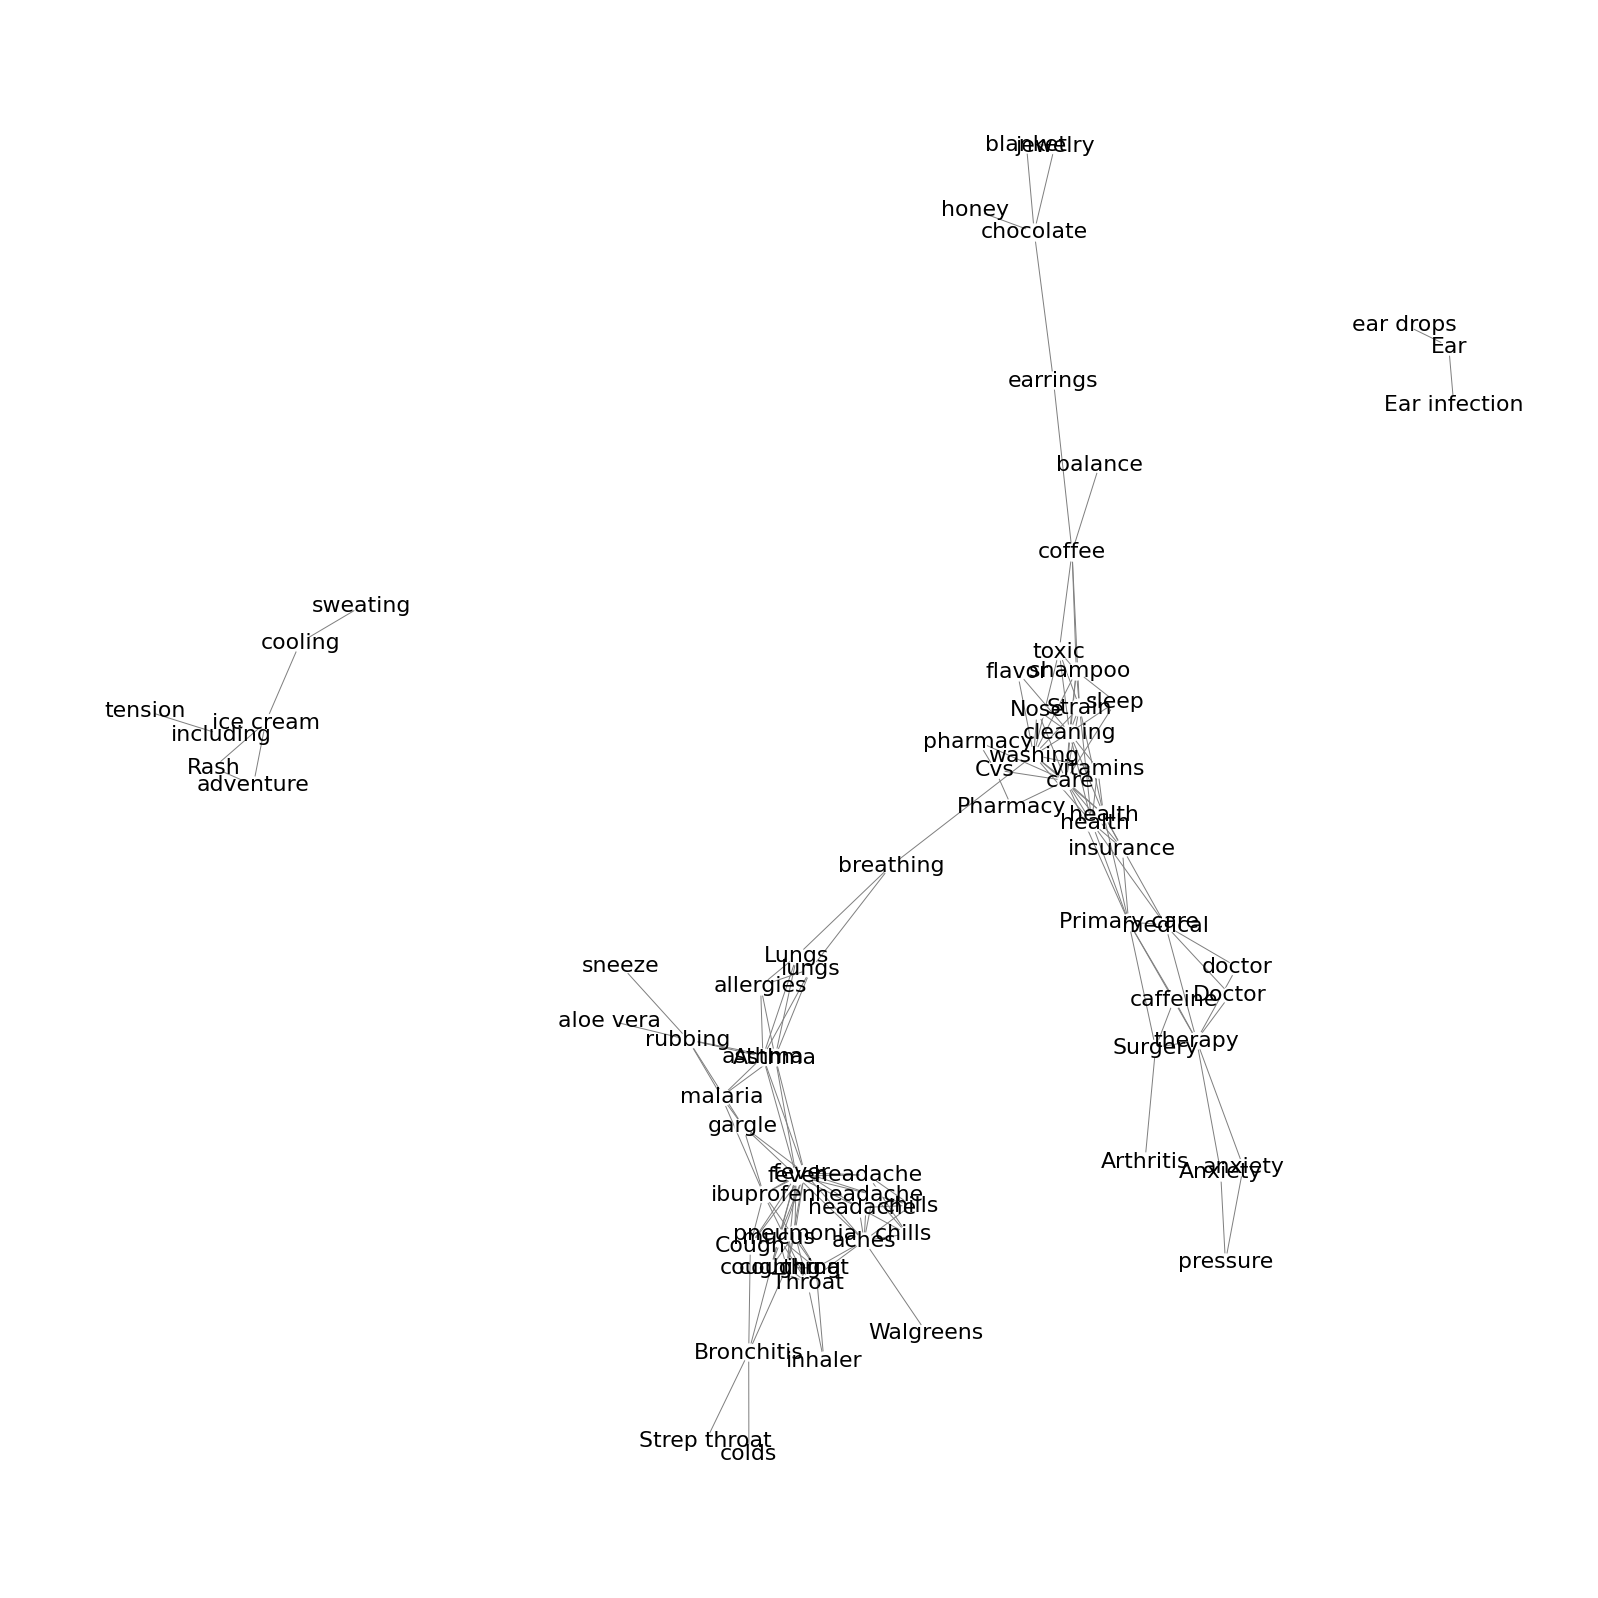

In [130]:
# time-based pairwise similiarity weights
df_slice = get_pairwise_similarity(df_features, gen_topics, std_factor*2)

# reduce to relevant relationships
df_slice = df_slice[(df_slice['weight']<0.85)]
df_slice = df_slice[df_slice['source'] != df_slice['target'] ]

# display flattened histogram
df_slice.hist()

# build graph
G = build_graph_network(df_slice)

In [131]:
# community detection

# community detection
c = list(greedy_modularity_communities(G))

# how many communities we detected
community_count=len(c)
print('Communities found - %s ' % community_count); print()

for community in range(community_count):
  
  print('Community %d - %s' % (community, sorted(c[community])))

Communities found - 7 

Community 0 - [' care', ' health', ' shampoo', 'Anxiety', 'Arthritis', 'Cvs', 'Doctor', 'Nose', 'Pharmacy', 'Primary care', 'Strain', 'Surgery', 'anxiety', 'caffeine', 'cleaning', 'doctor', 'flavor', 'health', 'insurance', 'medical', 'pharmacy', 'pressure', 'sleep', 'therapy', 'toxic', 'vitamins', 'washing']
Community 1 - [' coughing', 'Asthma', 'Bronchitis', 'Cough', 'Lungs', 'Strep throat', 'Throat', 'allergies', 'aloe vera', 'asthma', 'breathing', 'colds', 'coughing', 'fever', 'fever ', 'gargle', 'ibuprofen', 'inhaler', 'lungs', 'malaria', 'mucus', 'pneumonia', 'rubbing', 'sneeze', 'throat']
Community 2 - [' headache', 'Walgreens', 'aches', 'chills', 'chills ', 'headache', 'headache ']
Community 3 - ['balance', 'blanket', 'chocolate', 'coffee', 'earrings', 'honey', 'jewelry']
Community 4 - ['Rash', 'adventure', 'cooling', 'ice cream', 'sweating']
Community 5 - ['Ear', 'Ear infection', 'ear drops']
Community 6 - ['including', 'tension']


In [141]:
# existing community topics
chk_topics = list(df_slice['source'].unique())

# purposed community topics
new_topics = get_related_topics(df_slice)
print(new_topics)

# new topic list
gen_topics = list(set(swap_tokens(chk_topics, new_topics)))
print(gen_topics)


completed openai retrieval of batch 1 - 30 rows of 608

completed openai retrieval of batch 2 - 60 rows of 608

completed openai retrieval of batch 3 - 90 rows of 608

completed openai retrieval of batch 4 - 120 rows of 608

completed openai retrieval of batch 5 - 150 rows of 608

completed openai retrieval of batch 6 - 180 rows of 608

completed openai retrieval of batch 7 - 210 rows of 608

completed openai retrieval of batch 8 - 240 rows of 608

completed openai retrieval of batch 9 - 270 rows of 608

completed openai retrieval of batch 10 - 300 rows of 608

completed openai retrieval of batch 11 - 330 rows of 608

completed openai retrieval of batch 12 - 360 rows of 608

completed openai retrieval of batch 13 - 390 rows of 608

completed openai retrieval of batch 14 - 420 rows of 608

completed openai retrieval of batch 15 - 450 rows of 608

completed openai retrieval of batch 16 - 480 rows of 608

completed openai retrieval of batch 17 - 510 rows of 608

completed openai retrieva


completed retrieval of batch 1 - 30 rows of 324

completed retrieval of batch 2 - 60 rows of 324

completed retrieval of batch 3 - 90 rows of 324


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



completed retrieval of batch 4 - 120 rows of 324

completed retrieval of batch 5 - 150 rows of 324

completed retrieval of batch 6 - 180 rows of 324

completed retrieval of batch 7 - 210 rows of 324
failed to add topic - beans mug 

completed retrieval of batch 8 - 240 rows of 324

completed retrieval of batch 9 - 270 rows of 324

completed retrieval of batch 10 - 300 rows of 324


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':


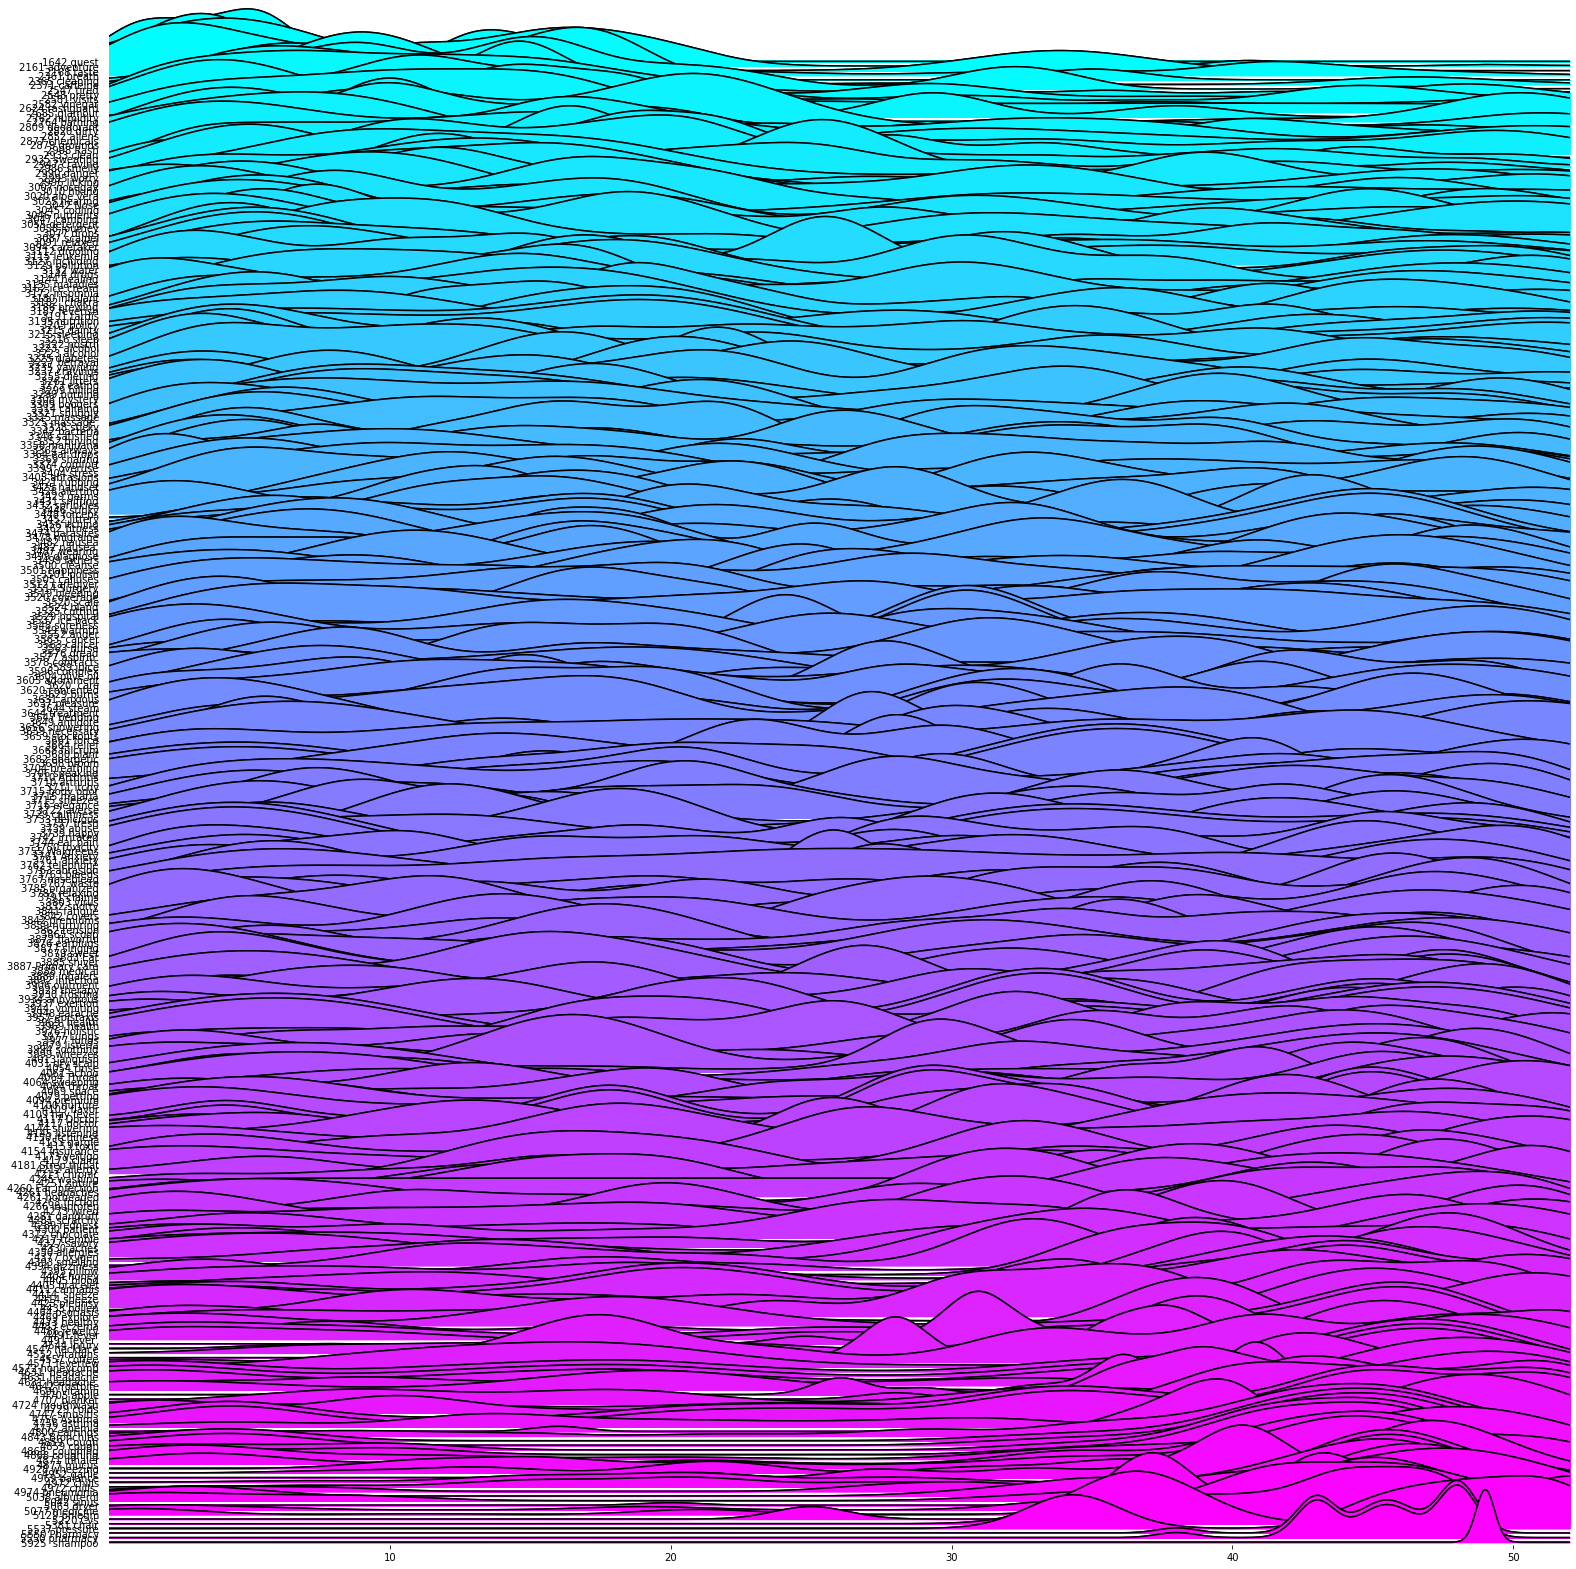

In [143]:
# request features
df_features = get_trend_frame(gen_topics, '5')

# normalize feature space
df_features=(df_features-df_features.mean())/df_features.std()

# flatten feature space vertically
df_flat = stack_nodes_vertically(df_features)

# build node labels
df_flat = build_node_labels(df_flat)

# display ridgeplot of events
get_ridgeplot(df_flat)

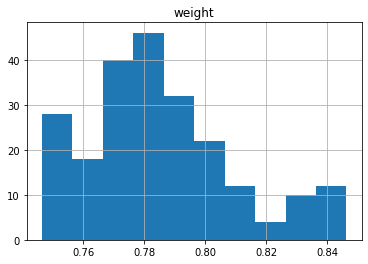

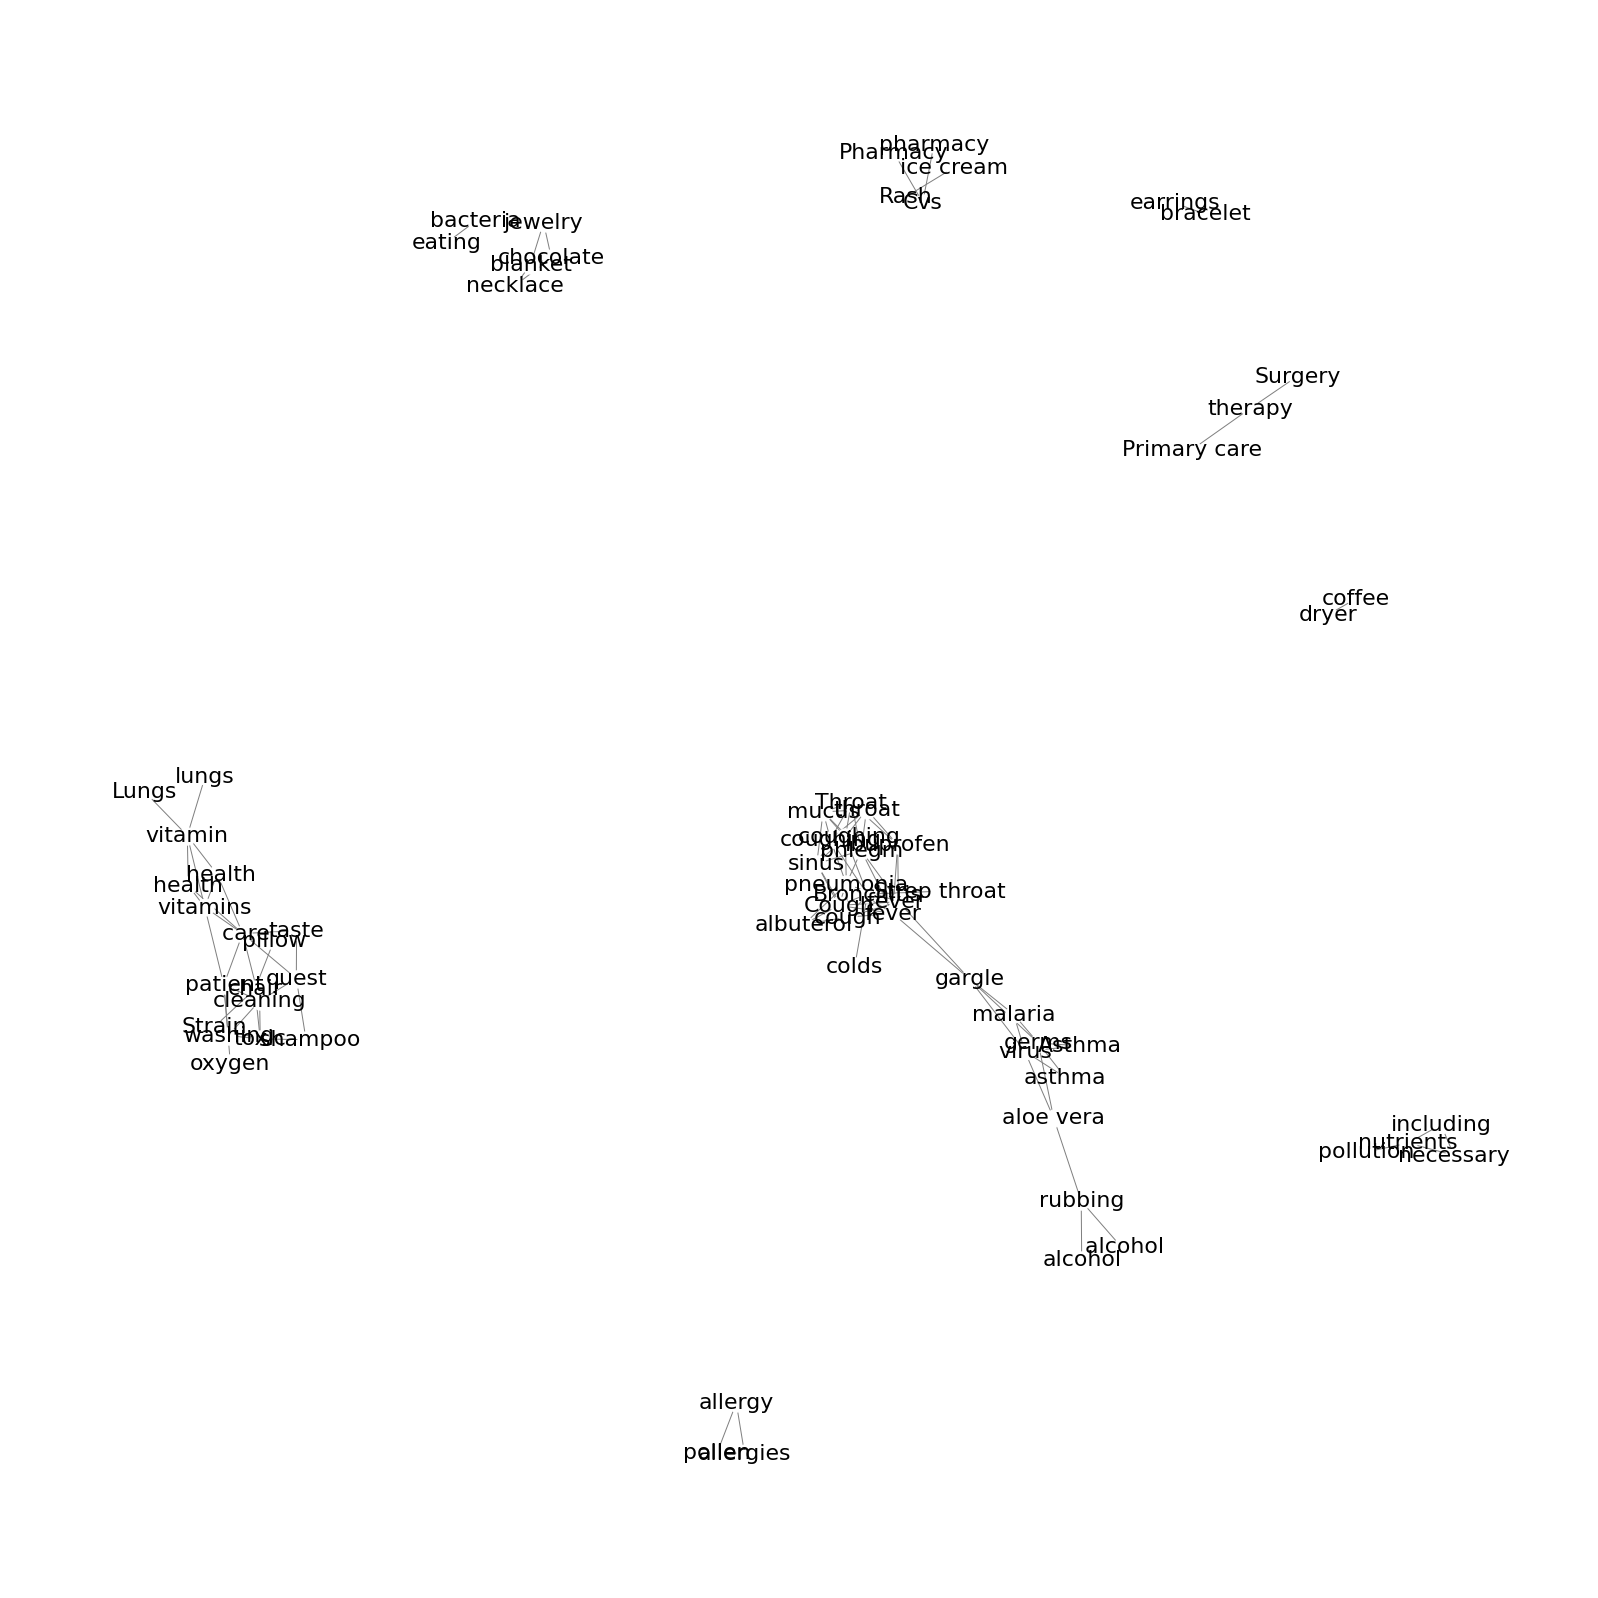

In [148]:
# time-based pairwise similiarity weights
df_slice = get_pairwise_similarity(df_features, gen_topics, std_factor*2.4)

# reduce to relevant relationships
df_slice = df_slice[(df_slice['weight']<0.85)]
df_slice = df_slice[df_slice['source'] != df_slice['target'] ]

# display flattened histogram
df_slice.hist()

# build graph
G = build_graph_network(df_slice)

In [149]:
# community detection

# community detection
c = list(greedy_modularity_communities(G))

# how many communities we detected
community_count=len(c)
print('Communities found - %s ' % community_count); print()

for community in range(community_count):
  
  print('Community %d - %s' % (community, sorted(c[community])))

Communities found - 12 

Community 0 - [' care', ' health', ' shampoo', 'Lungs', 'Strain', 'chair', 'cleaning', 'health', 'lungs', 'oxygen', 'patient', 'pillow', 'quest', 'taste', 'toxic', 'vitamin', 'vitamins', 'washing']
Community 1 - [' coughing', 'Bronchitis', 'Cough', 'Strep throat', 'Throat', 'albuterol', 'colds', 'cough', 'coughing', 'fever', 'fever ', 'ibuprofen', 'mucus', 'phlegm', 'pneumonia', 'sinus', 'throat']
Community 2 - [' alcohol', 'Asthma', 'alcohol', 'aloe vera', 'asthma', 'gargle', 'germs', 'malaria', 'rubbing', 'virus']
Community 3 - ['blanket', 'chocolate', 'jewelry', 'necklace']
Community 4 - ['including', 'necessary', 'nutrients', 'pollution']
Community 5 - ['allergies', 'allergy', 'pollen']
Community 6 - ['Primary care', 'Surgery', 'therapy']
Community 7 - ['Cvs', 'Pharmacy', 'pharmacy']
Community 8 - ['bacteria', 'eating']
Community 9 - ['Rash', 'ice cream']
Community 10 - ['coffee', 'dryer']
Community 11 - ['bracelet', 'earrings']
